In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from netam import shmoof, noof

In [2]:
full_shmoof_df = pd.read_csv("/Users/matsen/data/shmoof_edges_11-Jan-2023_NoNode0_iqtree_K80+R_masked.csv", index_col=0).reset_index(drop=True)

full_shmoof_df = full_shmoof_df.sample(5000)

train_df = full_shmoof_df.sample(frac=0.8)
val_df = full_shmoof_df.drop(train_df.index)

In [3]:
kmer_length = 5
max_length = 500

train_dataset = shmoof.SHMoofDataset(train_df, kmer_length=kmer_length, max_length=max_length)
val_dataset = shmoof.SHMoofDataset(val_df, kmer_length=kmer_length, max_length=max_length)

print(f"we have {len(train_dataset)} training examples and {len(val_dataset)} validation examples")

we have 4000 training examples and 1000 validation examples


In [4]:
model = shmoof.SHMoofModel(train_dataset)
burrito = shmoof.SHMoofBurrito(train_dataset, val_dataset, model, l2_regularization_coeff=1e-6)
print("starting training...")
losses = burrito.train(epochs=3)
burrito.write_shmoof_output("_ignore/reshmoof")

starting training...
Epoch [1/3]	 Loss: 0.03762468	 Val Loss: 0.03764709
Epoch [2/3]	 Loss: 0.03546290	 Val Loss: 0.03756397
Epoch [3/3]	 Loss: 0.03539965	 Val Loss: 0.03756045


In [6]:
model = shmoof.SHMoofModel(train_dataset)
burrito = shmoof.NoofBurrito(train_dataset, val_dataset, model, batch_size=1024, learning_rate=0.5, l2_regularization_coeff=1e-6)
print("starting training...")
losses = burrito.train(epochs=20)
burrito.write_shmoof_output("_ignore/reshmoof")

starting training...
Epoch [1/20]	 Loss: 0.043612952	 Val Loss: 0.039234668
Epoch [2/20]	 Loss: 0.036972112	 Val Loss: 0.039235286
Epoch [3/20]	 Loss: 0.036736619	 Val Loss: 0.038618587
Epoch [4/20]	 Loss: 0.036333773	 Val Loss: 0.038049035
Epoch [5/20]	 Loss: 0.035900632	 Val Loss: 0.037649397
Epoch [6/20]	 Loss: 0.035694363	 Val Loss: 0.037524033
Epoch [7/20]	 Loss: 0.035538005	 Val Loss: 0.037540078
Epoch [8/20]	 Loss: 0.035438528	 Val Loss: 0.037551504
Epoch [9/20]	 Loss: 0.035345408	 Val Loss: 0.037406363
Epoch [10/20]	 Loss: 0.035275488	 Val Loss: 0.037257969
Epoch [11/20]	 Loss: 0.035265941	 Val Loss: 0.037147138
Epoch [12/20]	 Loss: 0.035254837	 Val Loss: 0.037166551
Epoch [13/20]	 Loss: 0.035224921	 Val Loss: 0.037189081
Epoch [14/20]	 Loss: 0.035212441	 Val Loss: 0.037165742
Epoch [15/20]	 Loss: 0.035181511	 Val Loss: 0.037169013
Epoch [16/20]	 Loss: 0.035180591	 Val Loss: 0.037154768
Epoch [17/20]	 Loss: 0.03518826	 Val Loss: 0.037117243
Epoch [18/20]	 Loss: 0.035180787	 Val

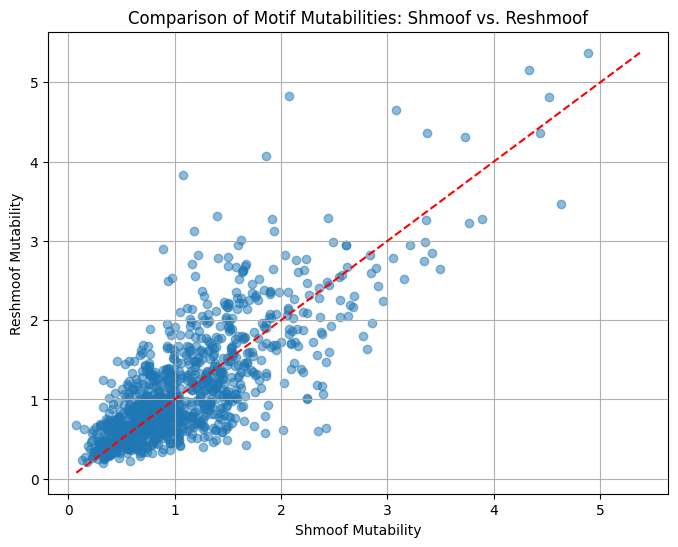

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load motif mutabilities
shmoof_motifs = pd.read_csv('_ignore/original_shmoof/mutabilities_context.tsv', sep='\t')
reshmoof_motifs = pd.read_csv('_ignore/reshmoof/motif_mutabilities.tsv', sep='\t')

# Merge dataframes
merged_motifs = pd.merge(shmoof_motifs, reshmoof_motifs, on='Motif', how='inner', suffixes=('_shmoof', '_reshmoof'))

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(merged_motifs['Mutability_shmoof'], merged_motifs['Mutability_reshmoof'], alpha=0.5)

# Determine bounds for y=x line
min_bound = min(merged_motifs['Mutability_shmoof'].min(), merged_motifs['Mutability_reshmoof'].min())
max_bound = max(merged_motifs['Mutability_shmoof'].max(), merged_motifs['Mutability_reshmoof'].max())

# Add y=x line
plt.plot([min_bound, max_bound], [min_bound, max_bound], 'r--')

plt.xlabel('Shmoof Mutability')
plt.ylabel('Reshmoof Mutability')
plt.title('Comparison of Motif Mutabilities: Shmoof vs. Reshmoof')
plt.grid(True)
plt.show()

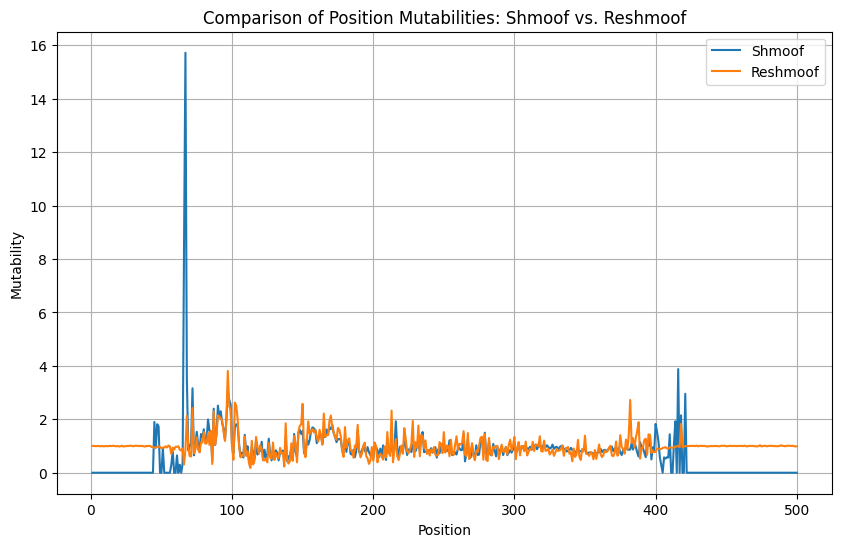

In [ ]:
# Load position mutabilities
shmoof_positions = pd.read_csv('_ignore/original_shmoof/mutabilities_position.tsv', sep='\t')
reshmoof_positions = pd.read_csv('_ignore/reshmoof/site_mutabilities.tsv', sep='\t')

# Merge dataframes
merged_positions = pd.merge(shmoof_positions, reshmoof_positions, on='Position', suffixes=('_shmoof', '_reshmoof'))
merged_positions.sort_values(by='Position', inplace=True)

# Line plot
plt.figure(figsize=(10, 6))
plt.plot(merged_positions['Position'], merged_positions['Mutability_shmoof'], label='Shmoof')
plt.plot(merged_positions['Position'], merged_positions['Mutability_reshmoof'], label='Reshmoof')
plt.xlabel('Position')
plt.ylabel('Mutability')
plt.title('Comparison of Position Mutabilities: Shmoof vs. Reshmoof')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
regularization_coeffs = [0, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4]

results = []

for coeff in regularization_coeffs:
    print(f"Training with regularization coefficient {coeff}")
    model = shmoof.SHMoofModel(train_dataset)
    burrito = noof.NoofBurrito(train_dataset, val_dataset, model, batch_size=1024, learning_rate=0.1, l2_regularization_coeff=1e-6)
    loss_history = burrito.train(epochs=20)
    final_training_loss = loss_history['training_losses'].iloc[-1]
    final_validation_loss = loss_history['validation_losses'].iloc[-1]

    results.append({
        'Regularization': coeff,
        'Final_Training_Loss': final_training_loss,
        'Final_Validation_Loss': final_validation_loss
    })

regularization_results_df = pd.DataFrame(results)
plt.figure(figsize=(10, 6))
plt.plot(regularization_results_df['Regularization'], regularization_results_df['Final_Training_Loss'], label='Training Loss', marker='o')
plt.plot(regularization_results_df['Regularization'], regularization_results_df['Final_Validation_Loss'], label='Validation Loss', marker='x')

plt.xscale('log')
plt.xlabel('Regularization Coefficient')
plt.ylabel('Loss')
plt.title('Effect of L2 Regularization on Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


Training with regularization coefficient 0
Epoch [1/20]	 Loss: 0.047570487	 Val Loss: 0.041866343
Epoch [2/20]	 Loss: 0.041202287	 Val Loss: 0.038574543
Epoch [3/20]	 Loss: 0.038476091	 Val Loss: 0.037142675
Epoch [4/20]	 Loss: 0.037268111	 Val Loss: 0.036491454
Epoch [5/20]	 Loss: 0.036699152	 Val Loss: 0.03616688
Epoch [6/20]	 Loss: 0.036399809	 Val Loss: 0.03596333
Epoch [7/20]	 Loss: 0.036197699	 Val Loss: 0.035836209
Epoch [8/20]	 Loss: 0.03608141	 Val Loss: 0.035757627
Epoch [9/20]	 Loss: 0.036013131	 Val Loss: 0.035724234
Epoch [10/20]	 Loss: 0.035964499	 Val Loss: 0.035689835
Epoch [11/20]	 Loss: 0.035924681	 Val Loss: 0.035668425
Epoch [12/20]	 Loss: 0.035894015	 Val Loss: 0.035648294
Epoch [13/20]	 Loss: 0.035874037	 Val Loss: 0.035640489
Epoch [14/20]	 Loss: 0.03587489	 Val Loss: 0.035627361
Epoch [15/20]	 Loss: 0.03585484	 Val Loss: 0.035616964
Epoch [16/20]	 Loss: 0.03585835	 Val Loss: 0.035613324
Epoch [17/20]	 Loss: 0.03584883	 Val Loss: 0.035612497
Epoch [18/20]	 Loss: 